## 함수

In [105]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from collections import Counter
import copy
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, convex_hull_plot_2d, QhullError

def plane_equation(a, b): # y = ax + b를 포함하고 xy평면에 수직인 평면의 방정식 구하는 함수
    # 평면 위에 있는 한 점 구하기: (0, b, 0)
    point = np.array([0, b, 0])
    # 평면의 법선 벡터: [-a, 1, 1]
    normal = np.array([-a, 1, 1])
    # d 계산: ax + by + cz = d
    d = np.dot(point, normal)

    return a, d # 평면의 방정식 반환: -ax + y + z = d

def is_point_on_plane(point, a, d): # point가 -ax + y + z = d 평면에 속하는 점인지 확인하는 함수
    # 주어진 점을 평면의 방정식에 대입
    result = -a * point[0] + point[1] + point[2]

    return result == d # 결과가 d와 같은지 확인하여 반환

def line_coefficients(point1, point2): # y = ax + b에서 a와 b구하는 함수
    # 기울기 a 구하기
    a = (point2[1] - point1[1]) / (point2[0] - point1[0])
    # 절편 b 구하기
    b = point1[1] - a * point1[0]

    return a, b
# 벽이 x축이나 y축에 수직이어서 위의 함수들을 사용하지는 않았지만 일반적인 다른 경우에는 사용할 수 있는 식임
def find_closest_y_points(points, target_x, y_range_min, y_range_max): # x값이 특정 값이고 y값이 어떤 범위에서 가장 가까이 있는 점부터 출력
    # x값이 target_x인 점들 선택
    filtered_points = points[points[:, 0] == target_x]

    # y값과 y_range 사이의 거리 계산
    y_distance = np.minimum(np.abs(filtered_points[:, 1] - y_range_min), np.abs(filtered_points[:, 1] - y_range_max))

    # y거리에 따라 점들 정렬
    sorted_points = filtered_points[np.argsort(y_distance)]
    # y거리 리스트로 반환
    sorted_y_distances = y_distance[np.argsort(y_distance)]

    return sorted_points, sorted_y_distances

def find_closest_x_points(points, target_y, x_range_min, x_range_max): # y값이 특정 값이고 x값이 어떤 범위에서 가장 가까이 있는 점부터 출력
    # y값이 target_y인 점들 선택
    filtered_points = points[points[:, 1] == target_y]

    # x값과 x_range 사이의 거리 계산
    x_distance = np.minimum(np.abs(filtered_points[:, 0] - x_range_min), np.abs(filtered_points[:, 0] - x_range_max))

    # x거리에 따라 점들 정렬
    sorted_points = filtered_points[np.argsort(x_distance)]
    # y거리 리스트로 반환
    sorted_x_distances = x_distance[np.argsort(x_distance)]

    return sorted_points, sorted_x_distances

def interpolate_points(point1, point2, spacing=0.2): # 점 늘려주는 함수
    # 두 점 사이의 거리 계산
    distance = np.linalg.norm(point2 - point1)

    # 거리와 간격을 사용하여 생성할 점의 개수를 결정
    num_points = int(distance / spacing) + 1

    # 두 점 사이에 일정한 간격으로 점을 생성
    x_values = np.linspace(point1[0], point2[0], num_points)
    y_values = np.linspace(point1[1], point2[1], num_points)
    z_values = np.linspace(point1[2], point1[2], num_points)

    interpolated_points = np.column_stack((x_values, y_values, z_values))
    
    return interpolated_points

def interpolate_points_z(point1, point2, spacing=0.2): # 점 늘려주는 함수
    # 두 점 사이의 거리 계산
    distance = np.linalg.norm(point2 - point1)

    # 거리와 간격을 사용하여 생성할 점의 개수를 결정
    num_points = int(distance / spacing) + 1

    # 두 점 사이에 일정한 간격으로 점을 생성
    x_values = np.linspace(point1[0], point2[0], num_points)
    y_values = np.linspace(point1[1], point2[1], num_points)
    z_values = np.linspace(point1[2], point2[2], num_points)

    interpolated_points = np.column_stack((x_values, y_values, z_values))
    
    return interpolated_points

def interpolate_points_z_up(point1, point2, spacing, height): # 위로 점 늘려주는 함수
    # 두 점 사이의 거리 계산
    distance = np.linalg.norm(point2 - point1)

    # 거리와 간격을 사용하여 생성할 점의 개수를 결정
    num_points = int(distance / spacing) + 1

    # 두 점 사이에 일정한 간격으로 점을 생성
    x_values = np.linspace(point1[0], point2[0], num_points)
    y_values = np.linspace(point1[1], point2[1], num_points)
    
    # 원하는 높이까지 z축으로 일정한 간격으로 점을 쌓기
    z_values = np.arange(0, height, spacing)
    
    # 생성된 점들을 조합하여 x, y, z 좌표로 이루어진 numpy 배열 반환
    grid_points = np.array([[[x, y, z] for x, y in zip(x_values, y_values)] for z in z_values])
    
    return grid_points.reshape(-1, 3)

### pcd 파일 불러오기
#### - deep copy 후 다운 샘플링 진행

In [2]:
pcd = o3d.io.read_point_cloud("./loaM/all_points_final.pcd")
print(pcd) # cnt points
print(np.asarray(pcd.points)) # print as arr

copypcd = copy.deepcopy(pcd) # 원래 pcd 복사
downpcd = copypcd.voxel_down_sample(0.05) # 적절한 voxel_size 설정
#o3d.visualization.draw_geometries([downpcd]) # 시각화
#o3d.io.write_point_cloud("downsampled_output.pcd", downpcd)

downarr = np.asarray(downpcd.points) # 배열로 변환
print(downarr)

PointCloud with 38002176 points.
[[ 3.92199993  1.74800003  0.59799999]
 [ 3.85599995  1.74399996  0.59100002]
 [ 3.79299998  1.74100006  0.58499998]
 ...
 [34.95310211  2.70623589  1.11135483]
 [34.85315323  2.68365097  1.11980975]
 [34.88591385  2.11594772  1.16189218]]
[[35.55511093  2.62350845  1.0565021 ]
 [38.26306152 -4.59296799  1.37001932]
 [38.70186615 -4.59177017  1.20123899]
 ...
 [34.81685638  2.42459931  1.86731303]
 [34.92055681 -4.33592982  1.86953506]
 [34.8617541  -0.73656255  1.86814944]]


### Z값만 추출하여 살펴봄
#### - z값의 분포를 통해 다른 점들에 비해 많이 높은 구간을 기둥 및 벽으로 함

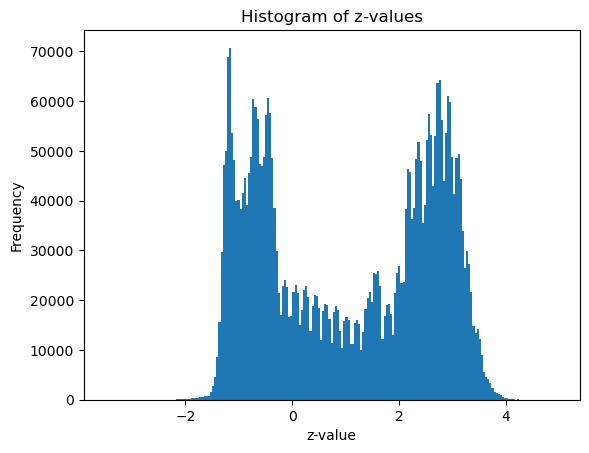

In [18]:
# plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
# inlier_cloud = pcd.select_by_index(inliers)
# outlier_cloud = pcd.select_by_index(inliers, invert=True)

# inlier_cloud.paint_uniform_color([1, 0, 0])
# outlier_cloud.paint_uniform_color([0.6, 0.6, 0.6])

# o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

# z값만 추출
z_values = np.asarray(downpcd.points)[:, 2]
# z값 시각화
# y 레이블: 해당 z값의 개수
plt.hist(z_values, bins='auto') # bins='auto': 적절한 구간 수를 자동으로 선택
plt.xlabel('z-value')
plt.ylabel('Frequency')
plt.title('Histogram of z-values')
plt.show()

#### pcd 점들 -> numpy

### z값이 최대인 점들의 평면 점들 pcd파일에 저장

In [4]:
# z값이 최대인 점들을 포함해서 z값 2 이상의 값들 extract
max_z_points = downarr[downarr[:, 2] > 2]

# 새로운 PointCloud 객체 생성하고 점들 할당
max_z_pcd = o3d.geometry.PointCloud()
max_z_pcd.points = o3d.utility.Vector3dVector(max_z_points)

# 새로운 PCD 파일에 z값이 최대인 점들 저장
output_file = 'max_z_points.pcd'
o3d.io.write_point_cloud(output_file, max_z_pcd)

True

### 위에서 바라본 pcd파일

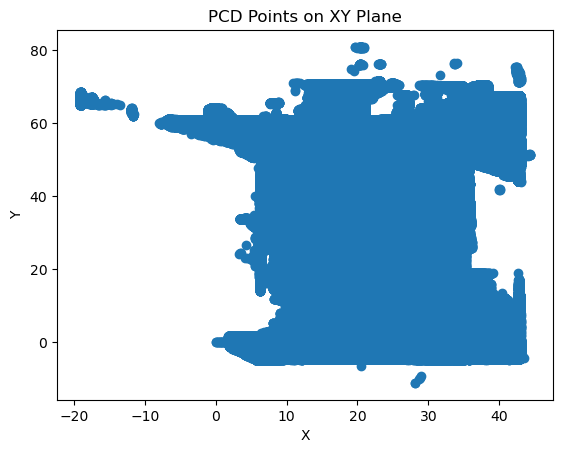

In [21]:
# x, y 좌표 추출
x_coords = downarr[:, 0]
y_coords = downarr[:, 1]

# 2D 그래프 그리기
plt.scatter(x_coords, y_coords)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("PCD Points on XY Plane")
plt.show()

### 각 좌표 값이 너무 상세해서 비교가 불가능하므로 반올림

In [4]:
# 반올림하여 다시 다운샘플링 pcd 저장
downarr[:,0]=np.round(downarr[:,0],1)
downarr[:,1]=np.round(downarr[:,1],1)
downarr[:,2]=np.round(downarr[:,2],1)

downpcd = o3d.geometry.PointCloud()
downpcd.points = o3d.utility.Vector3dVector(downarr)
# pcd 파일로 저장
o3d.io.write_point_cloud("downsampled_output.pcd", downpcd)

True

### 1. z 개수로 벽과 기둥 판단 

In [15]:
extract_z_cnt = []
# z 값이 최대인 점들 루프 돌며 
# 임의로 정한 개수와 해당 점의 수직선 상에 있는 점들의 개수가 같으면
# 벽 또는 기둥으로 가정하고 리스트에 추가
xy_downarr = downarr[:,:2] # x와 y좌표만 저장한 넘파이 배열 생성 (비교를 위해)
tuplelist_xy = [tuple(e) for e in xy_downarr] # counter 쓰기 위해 튜플로 변환
# 개수 세기
cnt_downarr = Counter(tuplelist_xy)
dic = dict(cnt_downarr)
cnt_dic = [key for key, value in dic.items() if value >= 100]  # 100 - 임의의 수로 변경 가능
list_keys = [list(key) for key in cnt_dic]
elements_over_100 = np.asarray(list_keys)

print(elements_over_100)

for point in downarr:
    for element in elements_over_100:
        if (point[0]==element[0]) and (point[1]==element[1]): # x, y가 포함되면
            extract_z_cnt.append(point)

# 리스트를 넘파이 배열로 변환
extract_z_cnt_2_numpy = np.array(extract_z_cnt)
#넘파이 배열을 open3d 포인트 클라우드 객체로 변환
extract_z_cnt_pcd = o3d.geometry.PointCloud()
extract_z_cnt_pcd.points = o3d.utility.Vector3dVector(extract_z_cnt_2_numpy)
# pcd 파일로 저장
o3d.io.write_point_cloud("extract_z_cnt.pcd", extract_z_cnt_pcd)

[[35.6  2.6]
 [38.3 -4.6]
 [38.7 -4.6]
 ...
 [11.5 -4.8]
 [12.2 -4.7]
 [18.3 -1.9]]


True

In [3]:
# 불러오기
extract_z_cnt_pcd = o3d.io.read_point_cloud("./extract_z_cnt.pcd")
extract_z_cnt_2_numpy = np.asarray(extract_z_cnt_pcd.points) # 배열로 변환

### 2. 노이즈 제거 (Statistical Outlier Removal)

In [4]:
# 가장 일반적인 노이즈 제거 방법
rm, ind = extract_z_cnt_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
# o3d.visualization.draw_geometries([rm]) # 시각화

rmarr = np.asarray(rm.points)

o3d.io.write_point_cloud("extract_z_and_removal.pcd", rm) # 파일 저장

True

### 3. DBSCAN Clustering

In [130]:
# 경차 너비가 1.6m인 점을 감안하여 
# eps(밀도를 계산하기 위한 거리) = 1.5 (m) -> 데이터 단위 m인 것 같음
# min_points = 50 (임의로 정함, 최적의 값 찾아도 됨)
dbscan = DBSCAN(eps=1.5, min_samples=50).fit(extract_z_cnt_2_numpy)

labels = dbscan.labels_ # 클러스터 레이블
# 클러스터 개수
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 61


In [131]:
unique_labels = np.unique(labels) # label별로 색 입히기
# colors = o3d.utility.Vector3dVector(
#     [np.random.rand(3) for _ in range(len(unique_labels))]
# )

# point_colors = [colors[label] for label in labels]
# # 색상 적용 및 시각화
# rm.colors = o3d.utility.Vector3dVector(point_colors)
# o3d.visualization.draw_geometries([rm])

In [132]:
# 클러스터별 포인트를 저장할 빈 리스트 생성
clusters_points = []

# 클러스터별로 포인트를저장
for unique_label in unique_labels:
    # 클러스터에 속한 포인트들 추출
    cluster_points = extract_z_cnt_2_numpy[labels == unique_label]
    # 클러스터별 포인트 리스트에 추가
    clusters_points.append(cluster_points)

clusters_points_arrays = [np.round(np.array(cluster_points),1) for cluster_points in clusters_points]

------  0


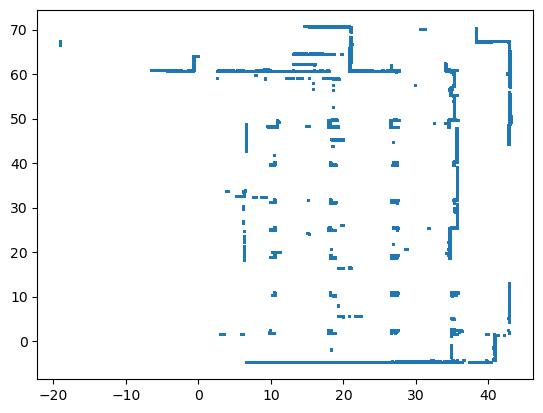

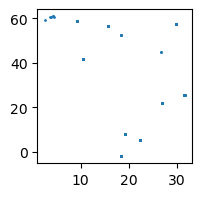

------  1


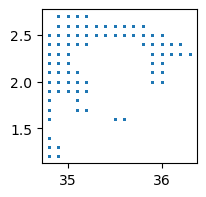

------  2


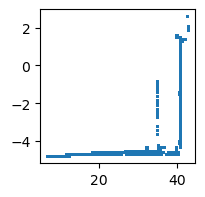

------  3


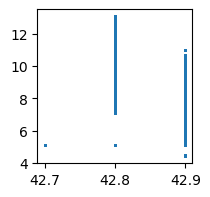

------  4


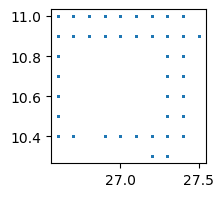

------  5


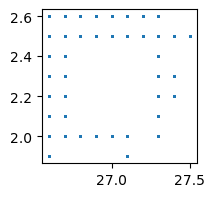

------  6


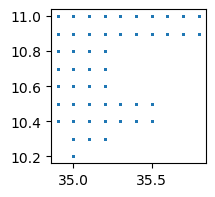

------  7


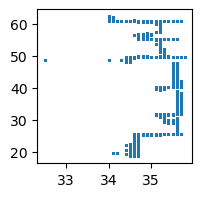

------  8


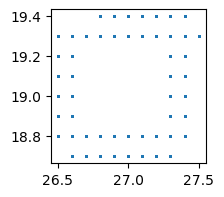

------  9


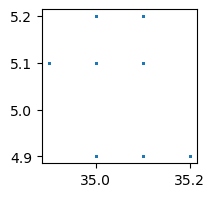

------  10


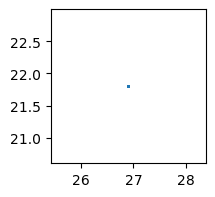

------  11


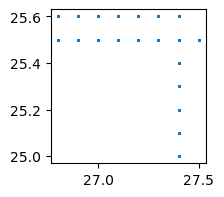

------  12


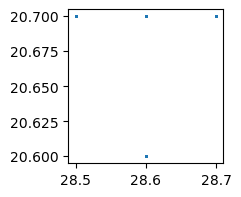

------  13


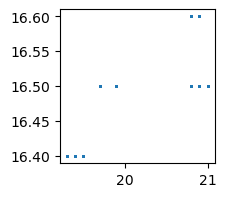

------  14


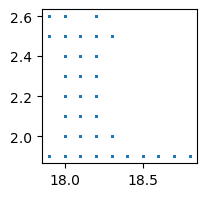

------  15


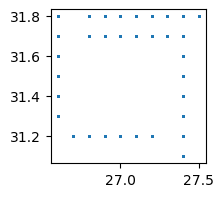

------  16


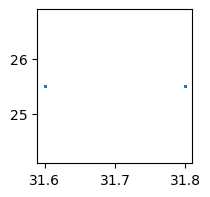

------  17


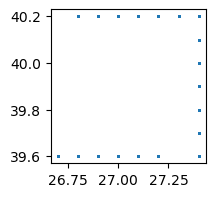

------  18


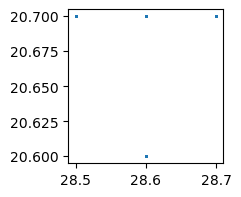

------  19


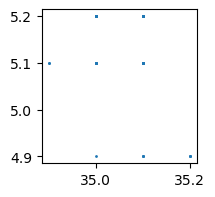

------  20


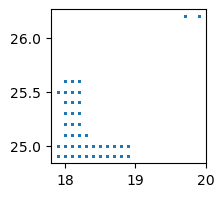

------  21


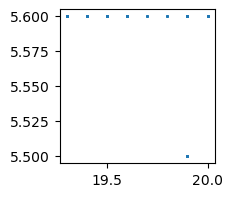

------  22


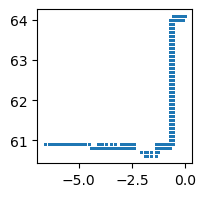

------  23


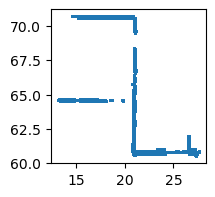

------  24


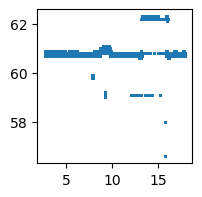

------  25


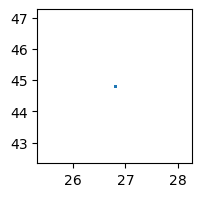

------  26


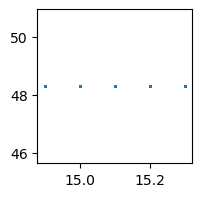

------  27


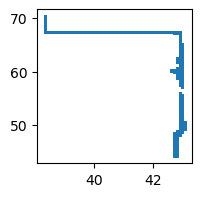

------  28


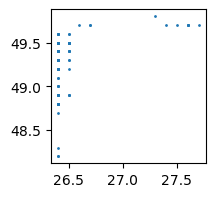

------  29


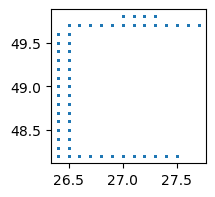

------  30


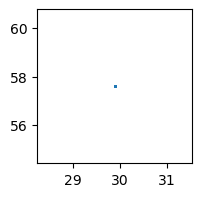

------  31


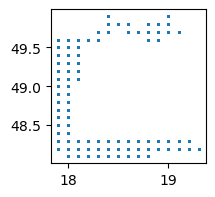

------  32


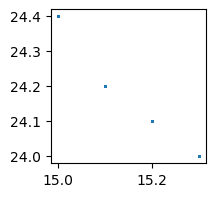

------  33


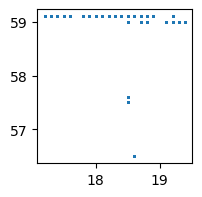

------  34


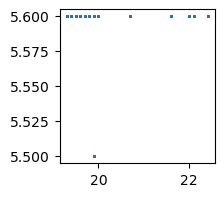

------  35


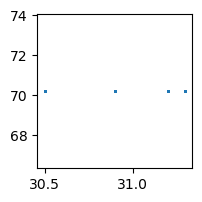

------  36


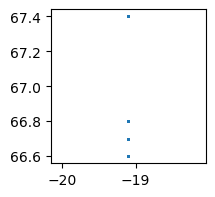

------  37


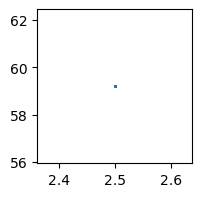

------  38


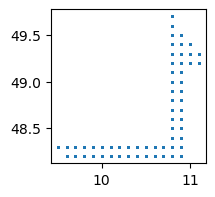

------  39


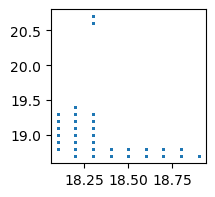

------  40


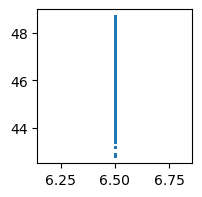

------  41


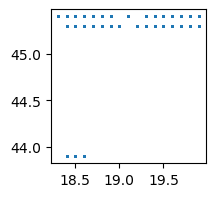

------  42


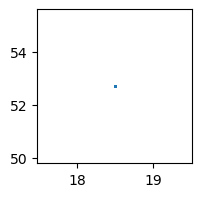

------  43


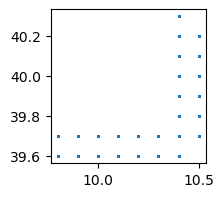

------  44


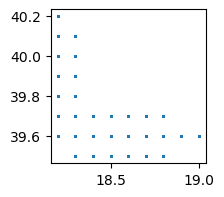

------  45


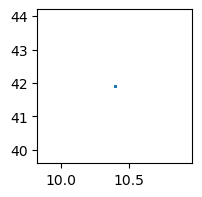

------  46


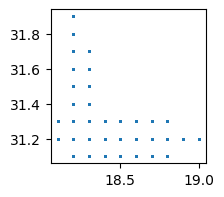

------  47


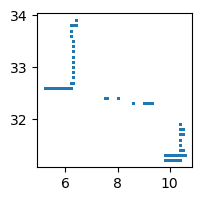

------  48


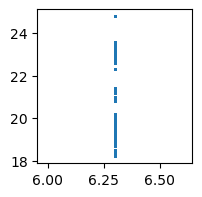

------  49


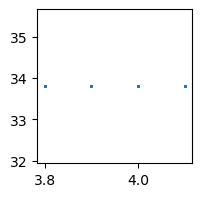

------  50


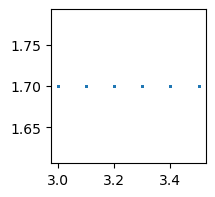

------  51


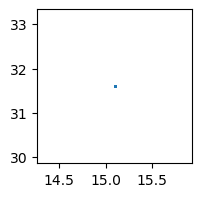

------  52


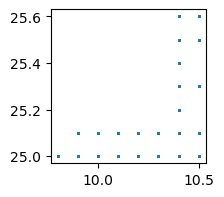

------  53


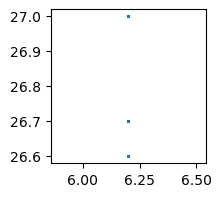

------  54


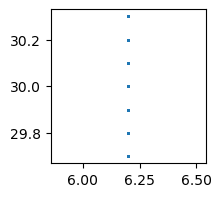

------  55


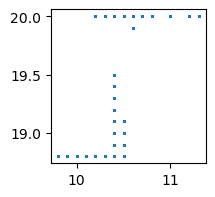

------  56


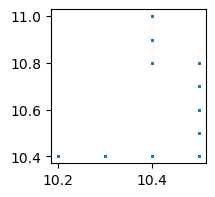

------  57


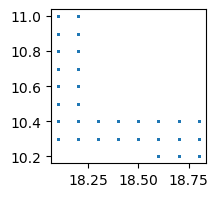

------  58


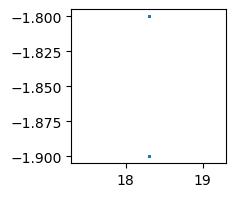

------  59


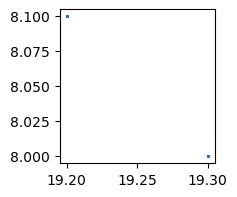

------  60


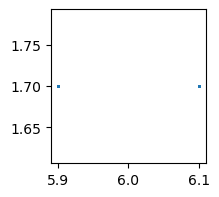

In [133]:
plt.scatter(extract_z_cnt_2_numpy[:,0],extract_z_cnt_2_numpy[:,1], s=1)

for i in range(n_clusters): # 버드아이뷰
    print("------ ", i)
    # print(clusters_points_arrays[0][:,0])
    plt.figure(figsize=(2, 2))
    plt.scatter(clusters_points_arrays[i][:,0],clusters_points_arrays[i][:,1], s=1)
    plt.show()

#### Convex Hull 알고리즘을 사용하여 기둥 분리
#### (모든 점을 포함하는 가장 작은 다각형의 넓이를 구한 뒤 비슷한 값들 나열)

----  0


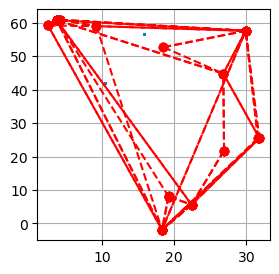

----  1


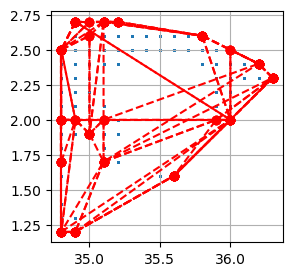

----  2


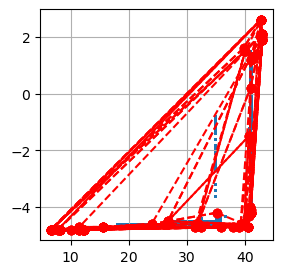

----  3


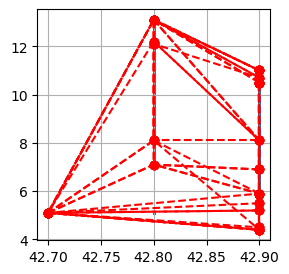

----  4


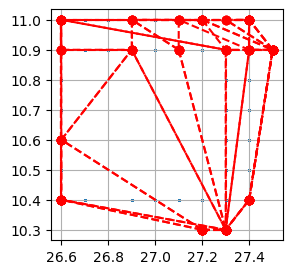

----  5


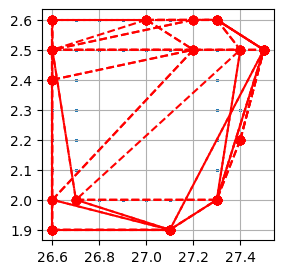

----  6


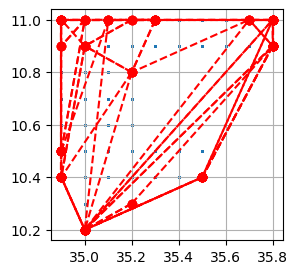

----  7


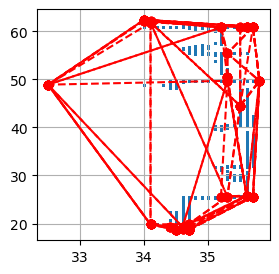

----  8


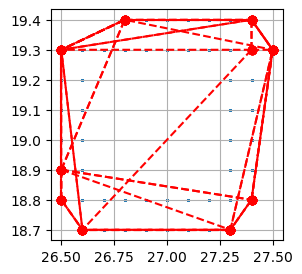

----  9


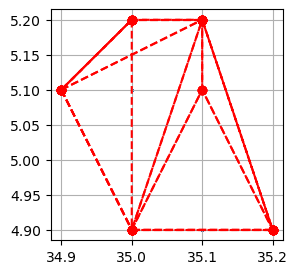

----  10
직선이거나 점임
----  11


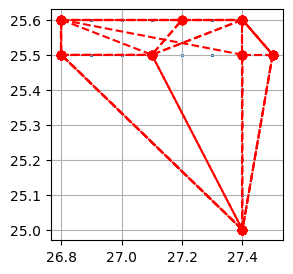

----  12


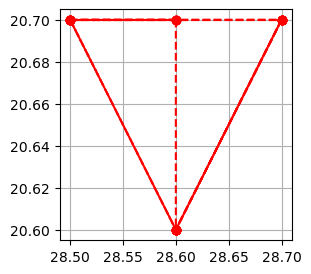

----  13


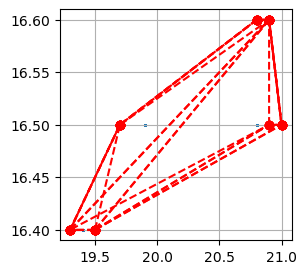

----  14


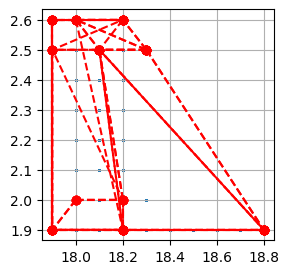

----  15


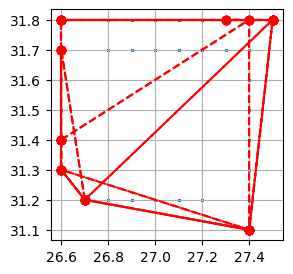

----  16
직선이거나 점임
----  17


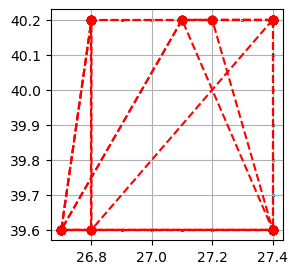

----  18


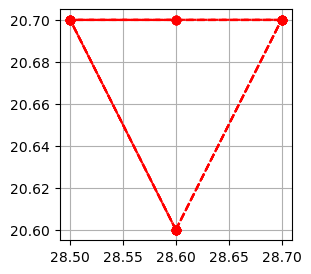

----  19


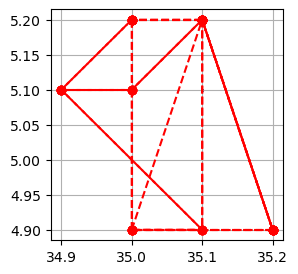

----  20


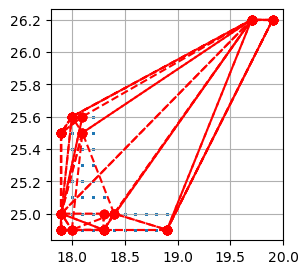

----  21


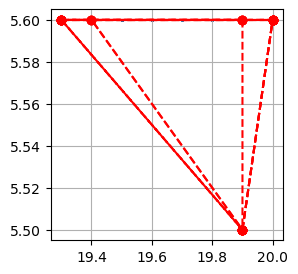

----  22


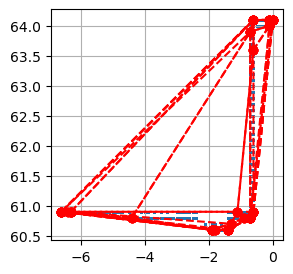

----  23


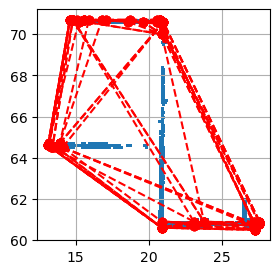

----  24


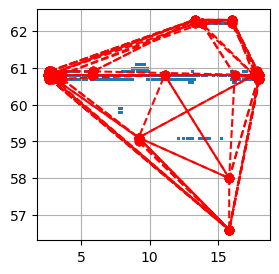

----  25
직선이거나 점임
----  26
직선이거나 점임
----  27


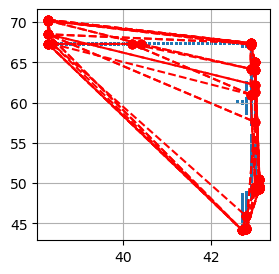

----  28


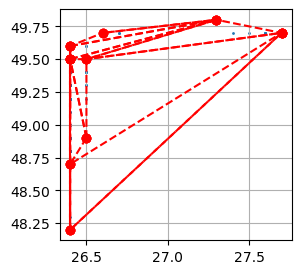

----  29


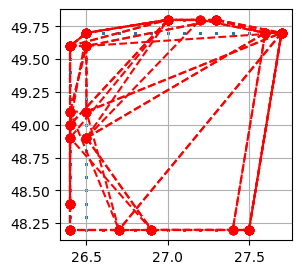

----  30
직선이거나 점임
----  31


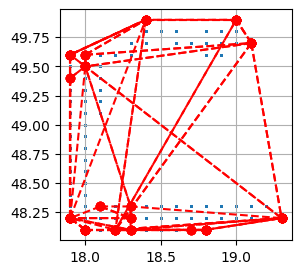

----  32


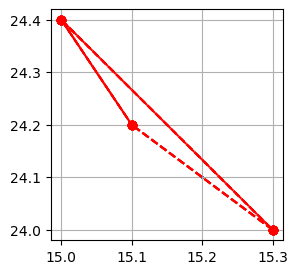

----  33


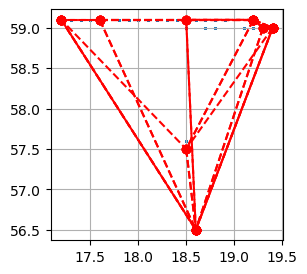

----  34


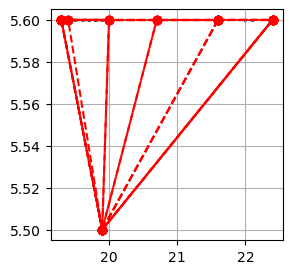

----  35
직선이거나 점임
----  36
직선이거나 점임
----  37
직선이거나 점임
----  38


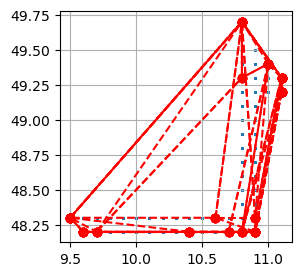

----  39


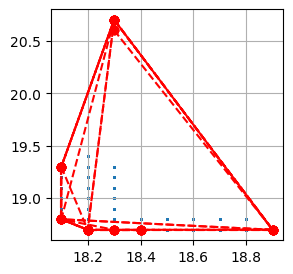

----  40
직선이거나 점임
----  41


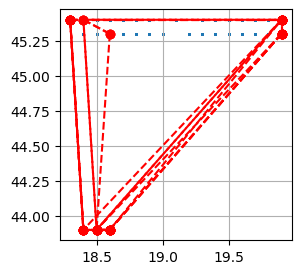

----  42
직선이거나 점임
----  43


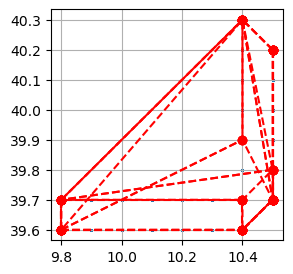

----  44


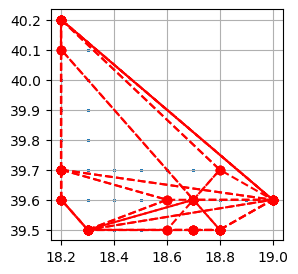

----  45
직선이거나 점임
----  46


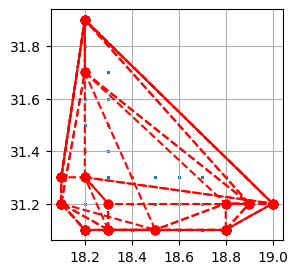

----  47


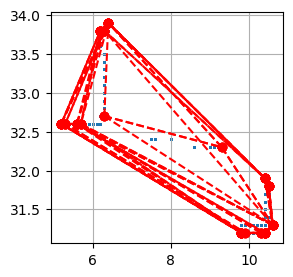

----  48
직선이거나 점임
----  49
직선이거나 점임
----  50
직선이거나 점임
----  51
직선이거나 점임
----  52


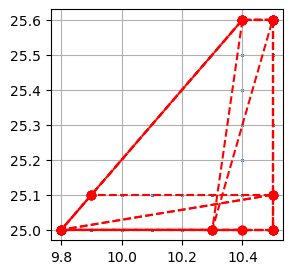

----  53
직선이거나 점임
----  54
직선이거나 점임
----  55


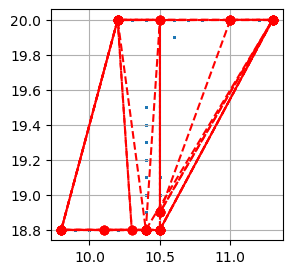

----  56


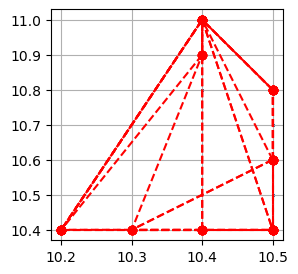

----  57


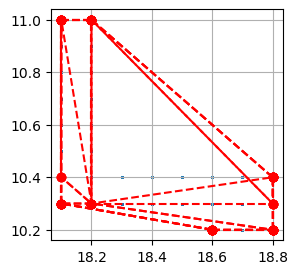

----  58
직선이거나 점임
----  59
직선이거나 점임
----  60
직선이거나 점임


In [9]:
cluster_area = []

for i in range(n_clusters):
    try: # 다각형이 만들어지지 않는 경우 예외 처리 -> 점, 직선
        hull = ConvexHull(clusters_points_arrays[i])
    except QhullError as e:
        print("---- ", i)
        print("직선이거나 점임")
        cluster_area.append(0)
        continue
    hull = ConvexHull(clusters_points_arrays[i])
    cluster_area.append(hull.area) # 넓이 저장
    # convex hull 적용 후 시각화
    print("---- ", i)
    plt.figure(figsize=(3,3))
    plt.scatter(clusters_points_arrays[i][:,0],clusters_points_arrays[i][:,1],s=1)
    plt.grid()

    for simplex in hull.simplices:
        plt.plot(clusters_points_arrays[i][simplex, 0], clusters_points_arrays[i][simplex, 1], 'r--')
        plt.plot(clusters_points_arrays[i][simplex, 0], clusters_points_arrays[i][simplex, 1], 'ro')

    plt.show()

#### 분포 확인
#### - 제일 많은 값이 0 근처이므로 제외하였다. 벽이 많아 직선으로 간주하여 0이 많은 것 같다.

[2559, 26, 569, 72, 12, 13, 15, 652, 14, 2, 0, 8, 1, 14, 12, 13, 0, 8, 1, 0, 24, 1, 94, 345, 240, 0, 0, 384, 2, 16, 0, 28, 2, 40, 9, 0, 0, 0, 23, 21, 0, 27, 0, 9, 11, 0, 13, 70, 0, 0, 0, 0, 8, 0, 0, 19, 4, 11, 0, 0, 0]


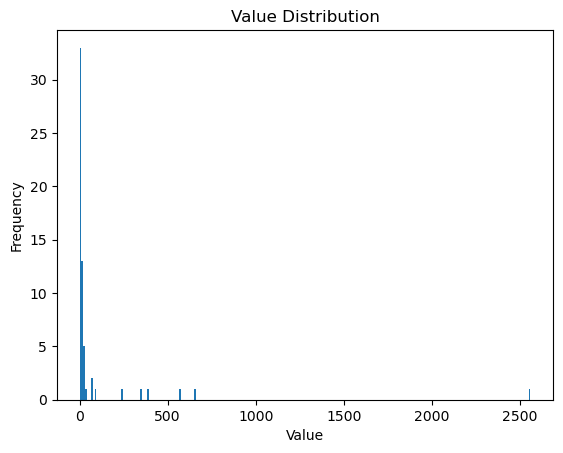

In [10]:
cluster_area = [round(x) for x in cluster_area] # 비교 쉽게 반올림

print(cluster_area)

plt.hist(cluster_area, bins='auto') # 전체 분포 확인

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Value Distribution')

plt.show()

구간별 빈도 :
[28  5  9  3  3  3  0  0  1  0  0  0  0  0  2  0  0  0  1  0]

구간의 경계 값 :
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]


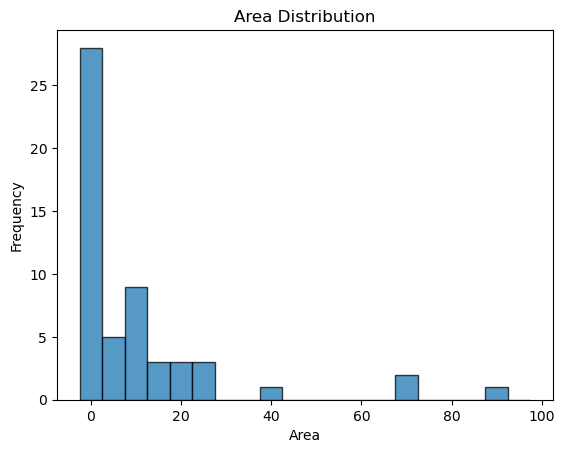

In [11]:
# numpy histogram 함수를 사용하여 구간별 데이터 얻음
# 범위는 위의 데이터를 보았을 때 빈도 수가 대략 100 안쪽에 몰려있으므로 집중 판단
hist, bin_edges = np.histogram(cluster_area, bins=20, range=(0, 100))

# 구간별 빈도수 출력
print("구간별 빈도 :")
print(hist)

# 구간의 경계 값 출력
print("\n구간의 경계 값 :")
print(bin_edges)
# 분포 확인
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="k", alpha=0.75)
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Area Distribution')

plt.show()

###### pcd 파일을 확인해보았을 때, 기둥 모양이 직사각형 혹은 기역/니은 모양으로 스캔되었다.
###### 기역/니은 모양은 hull 적용 후에 넓이를 계산하였을 때 대략 삼각형의 모양이 나오므로
###### 삼각형의 2배가 직사각형이기 때문에 몰려있는 값의 2배인 값도 고려해야 한다.
###### 가장 많이 몰려 있는 0 근처의 구간은 노이즈라고 생각하고 이 외에 3이상 30 이하의 값들을 기둥으로 간주한다.

In [16]:
pillar_cluster_idx = []

for i in range(len(cluster_area)):
    if cluster_area[i] >= 3 and cluster_area[i] < 30:
        pillar_cluster_idx.append(i)
    else:
        continue

print(pillar_cluster_idx)
print(len(pillar_cluster_idx))

[1, 4, 5, 6, 8, 11, 13, 14, 15, 17, 20, 29, 31, 34, 38, 39, 41, 43, 44, 46, 52, 55, 56, 57]
24


### 기둥 후보들
### [1, 4, 5, 6, 8, 11, 13, 14, 15, 17, 20, 29, 31, 34, 38, 39, 41, 43, 44, 46, 52, 55, 56, 57]

----  1


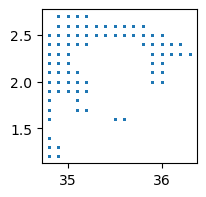

----  4


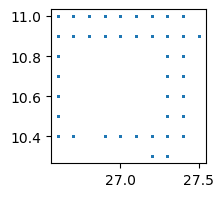

----  5


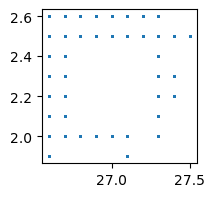

----  6


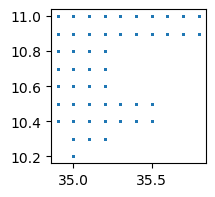

----  8


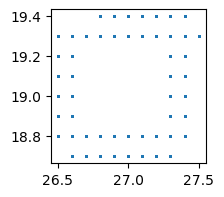

----  11


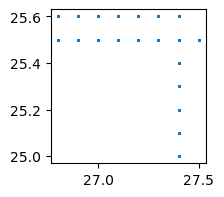

----  13


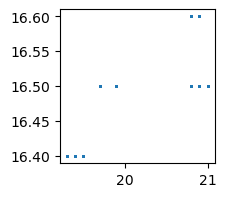

----  14


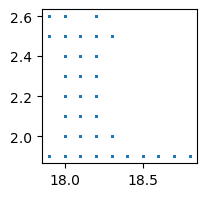

----  15


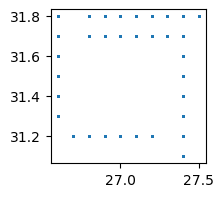

----  17


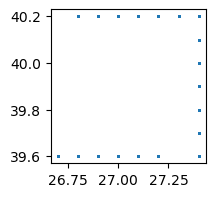

----  20


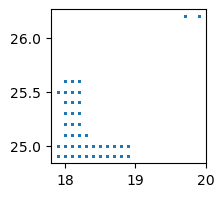

----  29


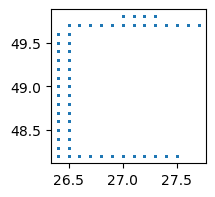

----  31


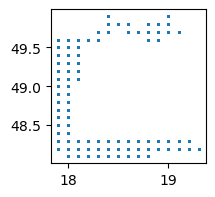

----  34


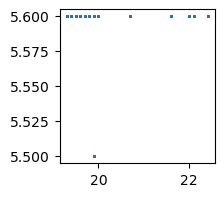

----  38


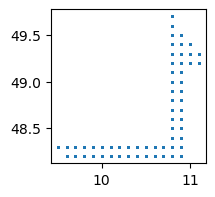

----  39


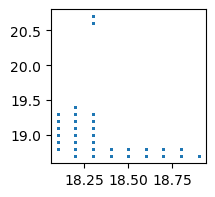

----  41


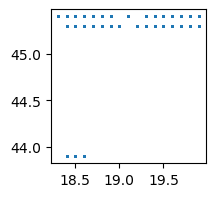

----  43


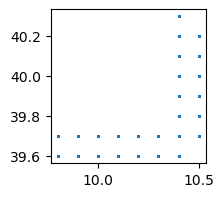

----  44


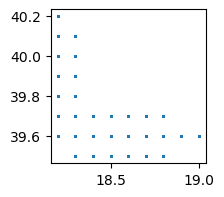

----  46


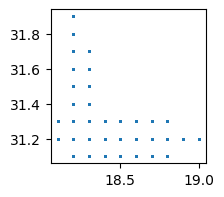

----  52


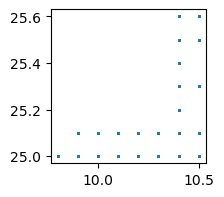

----  55


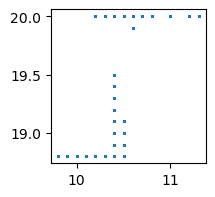

----  56


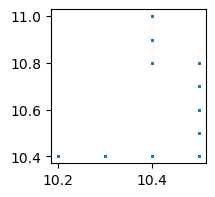

----  57


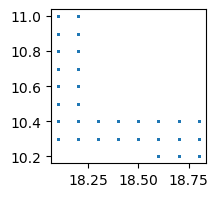

In [17]:
for i in range(len(pillar_cluster_idx)):
    index = pillar_cluster_idx[i]
    print("---- ", index)
    plt.figure(figsize=(2, 2))
    plt.scatter(clusters_points_arrays[index][:,0],clusters_points_arrays[index][:,1], s=1)
    plt.show()

### 2차 검출 - z 좌표 비교 (max)

[3.8, 3.6, 3.6, 3.7, 3.7, 3.6, 3.3, 3.7, 3.5, 2.9, 3.2, 3.4, 3.3, 1.0, 3.3, 3.7, 3.3, 3.3, 3.0, 3.5, 3.1, 3.6, 1.7, 3.7]


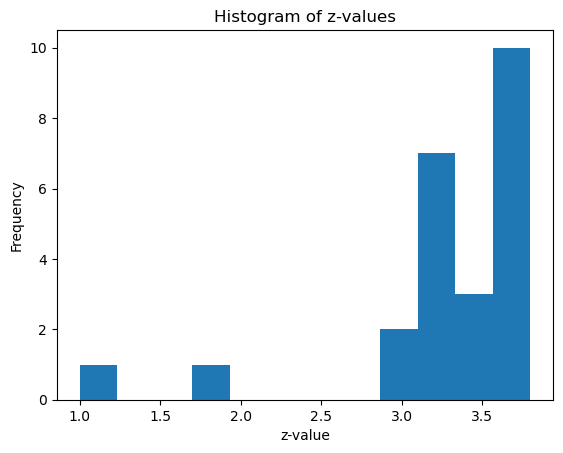

In [18]:
z_pillar = []

for i in range(len(pillar_cluster_idx)):
    index = pillar_cluster_idx[i]

    z_pillar.append(np.max(clusters_points_arrays[index][:,2]))

print(z_pillar)
# z값 시각화
# y 레이블: 해당 z값의 개수
plt.hist(z_pillar, bins='auto') # bins='auto': 적절한 구간 수를 자동으로 선택
plt.xlabel('z-value')
plt.ylabel('Frequency')
plt.title('Histogram of z-values')
plt.show()

In [20]:
print(pillar_cluster_idx)
for i in range(len(pillar_cluster_idx)):
    index = pillar_cluster_idx[i]

    if index < 2:
        pillar_cluster_idx.remove(index)

print(pillar_cluster_idx)

[4, 5, 6, 8, 11, 13, 14, 15, 17, 20, 29, 31, 34, 38, 39, 41, 43, 44, 46, 52, 55, 56, 57]
[4, 5, 6, 8, 11, 13, 14, 15, 17, 20, 29, 31, 34, 38, 39, 41, 43, 44, 46, 52, 55, 56, 57]


### z값이 일정하게 있는지 확인 -> 없으면 기둥 아님

----  4


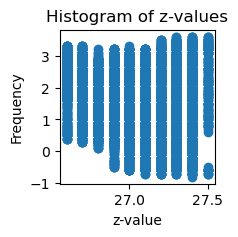

----  5


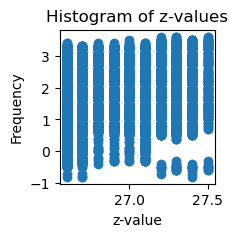

----  6


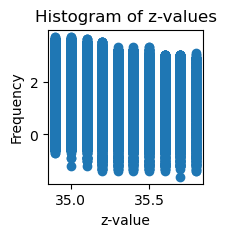

----  8


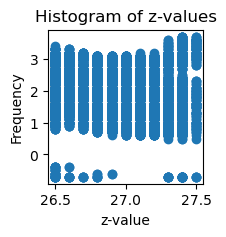

----  11


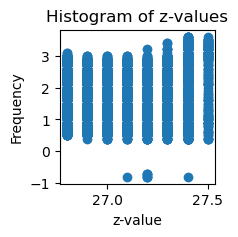

----  13


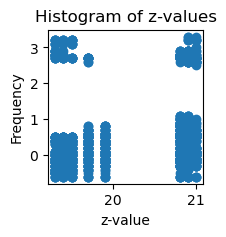

----  14


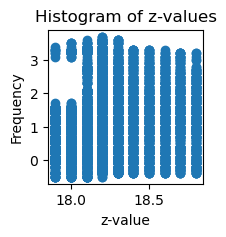

----  15


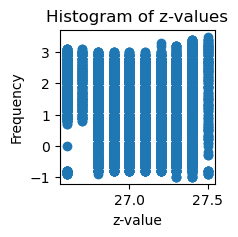

----  17


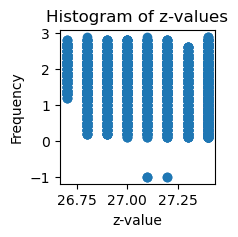

----  20


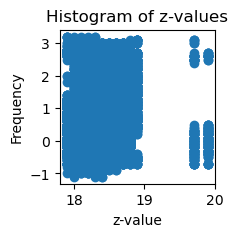

----  29


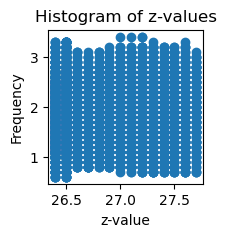

----  31


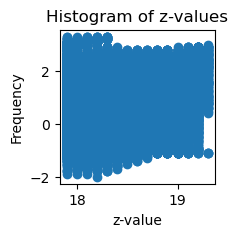

----  34


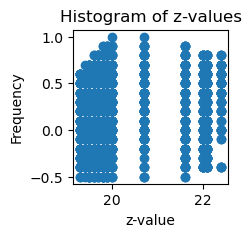

----  38


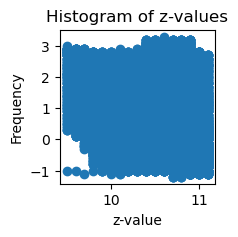

----  39


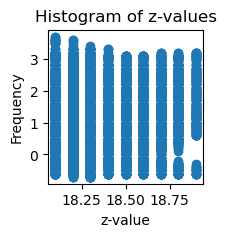

----  41


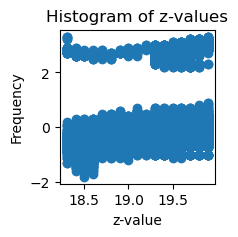

----  43


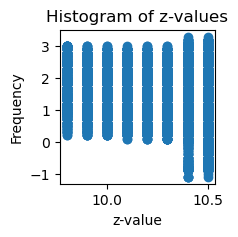

----  44


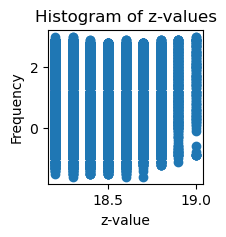

----  46


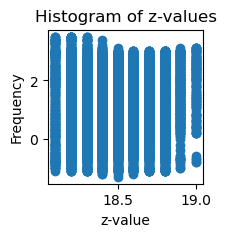

----  52


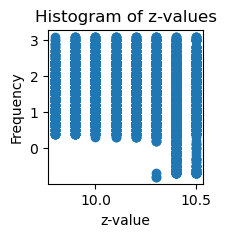

----  55


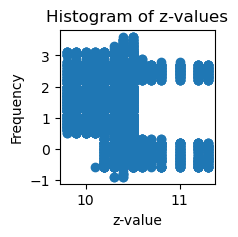

----  56


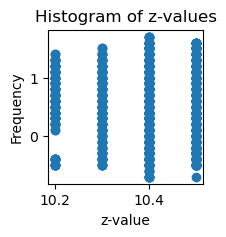

----  57


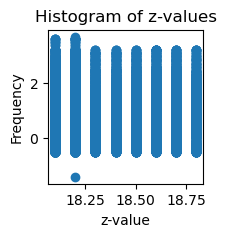

In [21]:
for i in range(len(pillar_cluster_idx)):
    index = pillar_cluster_idx[i]

    print("---- ",index)
    plt.figure(figsize=(2, 2))
    plt.scatter(clusters_points_arrays[index][:,0],clusters_points_arrays[index][:,2])
    plt.xlabel('z-value')
    plt.ylabel('Frequency')
    plt.title('Histogram of z-values')
    plt.show()

### 최종 기둥 클러스터

In [22]:
# 이상한 값 삭제
pillar_cluster_idx.remove(13)
print(pillar_cluster_idx)

[4, 5, 6, 8, 11, 14, 15, 17, 20, 29, 31, 34, 38, 39, 41, 43, 44, 46, 52, 55, 56, 57]


### 최종 기둥 cluster idx 완성
### [4, 5, 6, 8, 11, 14, 15, 17, 20, 29, 31, 34, 38, 39, 41, 43, 44, 46, 52, 55, 56, 57]

### 4. 평면 방정식으로 벽 검출
#### - cluster한 걸로 변수를 여러 개로 나누어 저장

In [70]:
# [1, 4, 5, 6, 8, 11, 13, 14, 15, 17, 20, 29, 31, 34, 38, 39, 41, 43, 44, 46, 52, 55, 56, 57] -> 기둥 후보들은 벽이 될 수 없음
# 위에서 변수로 저장해도 되지만 편의를 위해 미리 값을 따둠
pillar_candidate = [1, 4, 5, 6, 8, 11, 13, 14, 15, 17, 20, 29, 31, 34, 38, 39, 41, 43, 44, 46, 52, 55, 56, 57]
noise_rm_wall = []

for i in range(n_clusters):
    if i not in pillar_candidate:
        tmp_list = [array.tolist() for array in clusters_points_arrays[i][:,:]]
        for e in tmp_list:
            noise_rm_wall.append(e)

tmp_pcd = o3d.geometry.PointCloud()
tmp_pcd.points = o3d.utility.Vector3dVector(np.array(noise_rm_wall))

cl, ind = tmp_pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.1)

o3d.io.write_point_cloud("noise_remove_wall.pcd", cl) # 파일 저장

True

In [71]:
cl_np = np.asarray(cl.points)
dbscan_wall = DBSCAN(eps=2.0, min_samples=200).fit(cl_np)
wall_labels = dbscan_wall.labels_
wall_clusters = len(set(wall_labels)) - (1 if -1 in wall_labels else 0)
print(f"Number of wall clusters: {wall_clusters}")
wall_unique_labels = np.unique(labels)

Number of wall clusters: 13


In [72]:
# 클러스터별 포인트를 저장할 빈 리스트 생성
clusters_wall_points = []

# 클러스터별로 포인트를저장
for unique_label in wall_unique_labels:
    # 클러스터에 속한 포인트들 추출
    cluster_points = cl_np[wall_labels == unique_label]
    # 클러스터별 포인트 리스트에 추가
    clusters_wall_points.append(cluster_points)

clusters_wall_points_arrays = [np.round(np.array(cluster_points),1) for cluster_points in clusters_wall_points]

------  0


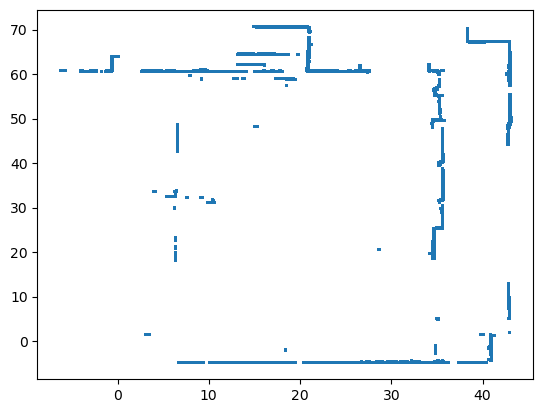

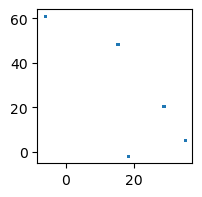

------  1


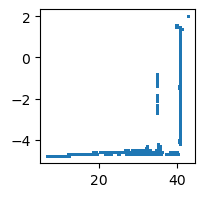

------  2


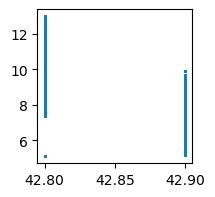

------  3


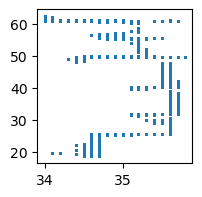

------  4


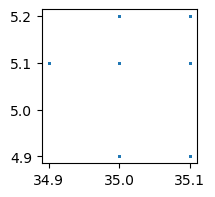

------  5


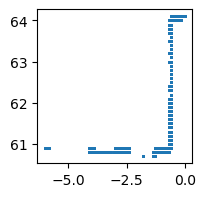

------  6


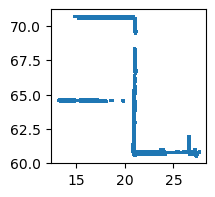

------  7


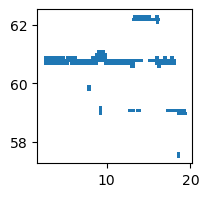

------  8


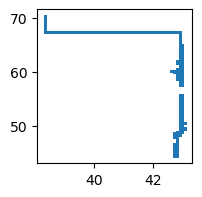

------  9


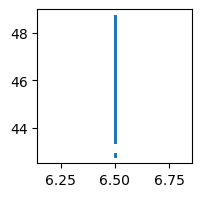

------  10


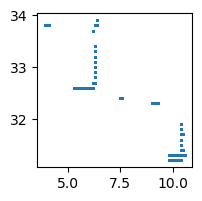

------  11


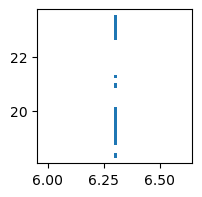

------  12


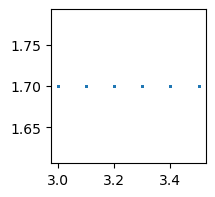

In [73]:
plt.scatter(cl_np[:,0],cl_np[:,1],s=1)

for i in range(wall_clusters): # 버드아이뷰
    print("------ ", i)

    plt.figure(figsize=(2, 2))
    plt.scatter(clusters_wall_points_arrays[i][:,0],clusters_wall_points_arrays[i][:,1], s=1)
    plt.show()

#### 수동 노이즈 삭제 (기둥 위치 근처에 있는 것들) 및 수동 포인트 늘리기
#### 눈에 띄게 비어있는 벽 부분을 평면의 방정식으로 원래 포인트와 비교하며 늘린다.
#### 기준 거리는 1.5

In [74]:
# 0, 4, 10 -> noise
wall_cluster_idx = [x for x in range(wall_clusters) if x not in (0, 4, 10)]
print(wall_cluster_idx)

[1, 2, 3, 5, 6, 7, 8, 9, 11, 12]


In [75]:
print(clusters_wall_points_arrays)

[array([[28.6, 20.6,  0.2],
       [28.6, 20.6,  0.2],
       [28.6, 20.6,  0.2],
       ...,
       [18.3, -1.8,  3. ],
       [18.3, -1.9,  2.8],
       [18.3, -1.9,  2.7]]), array([[38.3, -4.6,  1.4],
       [38.7, -4.6,  1.2],
       [38.9, -4.6,  0.7],
       ...,
       [40.9, -0.5,  1.8],
       [40.9, -0.9,  1.6],
       [40.9, -4. ,  1.6]]), array([[42.9,  8.3,  1.3],
       [42.9,  8.4,  1.3],
       [42.9,  8.5,  1.3],
       ...,
       [42.8, 12.1,  2.8],
       [42.9,  6.6,  2. ],
       [42.9,  9.9,  2. ]]), array([[34.5, 18.9,  0.4],
       [34.5, 18.8,  0.4],
       [34.5, 18.7,  0.4],
       ...,
       [34. , 61.4,  1.9],
       [34.6, 20. , -0.2],
       [34.6, 19.4,  1.9]]), array([[35.1,  4.9,  1.9],
       [35.1,  4.9,  2.1],
       [35.1,  4.9,  1.8],
       ...,
       [35. ,  5.2,  3.5],
       [34.9,  5.1,  1.9],
       [34.9,  5.1,  1.8]]), array([[-2.6, 60.9,  2.3],
       [-2.6, 60.9,  2.3],
       [-2.5, 60.8, -0.4],
       ...,
       [-0.7, 60.8, -0.1],

In [76]:
copyarr = np.asarray(copypcd.points) # 동일하게 반올림하여 비교

copyarr[:,0]=np.round(copyarr[:,0],1)
copyarr[:,1]=np.round(copyarr[:,1],1)
copyarr[:,2]=np.round(copyarr[:,2],1)

##### 늘려줄 cluster 레이블
##### 9 - x축에 수직인 벽 (x=a)

이전의 개수:  5179
랜덤한 2개의 점:  [[ 6.5 46.1  1.3]
 [ 6.5 45.2  2.1]]
증가된 개수:  422207


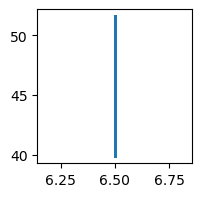

In [77]:
random_pts = np.random.choice(clusters_wall_points_arrays[9].shape[0], 2, replace=False) # 2개의 랜덤한 레이블에 속한 점 저장
selected_elements = clusters_wall_points_arrays[9][random_pts]
print("이전의 개수: ", clusters_wall_points_arrays[9].shape[0])
print("랜덤한 2개의 점: ", selected_elements)

# 평면의 방정식 -> x = selected_elements[0][0]
min = np.min(clusters_wall_points_arrays[9][:,1]) # 현재 클러스터 점들 범위
max = np.max(clusters_wall_points_arrays[9][:,1])

closest_pt, sorted_distances = find_closest_y_points(copyarr, selected_elements[0][0], min, max)

for i in range(closest_pt.shape[0]):
    if sorted_distances[i] >= 3.0: #자동차 지나가는 길 생각해서 3.0m로 잡음
        break
    elif abs(min - closest_pt[i][1]) < abs(max - closest_pt[i][1]):
        increase_pt = interpolate_points([selected_elements[0][0], min, selected_elements[0][2]], closest_pt[i])
        clusters_wall_points_arrays[9] = np.vstack((clusters_wall_points_arrays[9], increase_pt))
        min = closest_pt[i][1]
    elif abs(min - closest_pt[i][1]) > abs(max - closest_pt[i][1]):
        increase_pt = interpolate_points([selected_elements[0][0], max, selected_elements[0][2]], closest_pt[i])
        clusters_wall_points_arrays[9] = np.vstack((clusters_wall_points_arrays[9], increase_pt))
        max = closest_pt[i][1]

print("증가된 개수: ", clusters_wall_points_arrays[9].shape[0])
plt.figure(figsize=(2, 2))
plt.scatter(clusters_wall_points_arrays[9][:,0],clusters_wall_points_arrays[9][:,1], s=1)
plt.show()

##### 12 - y축에 수직인 벽 (y=a)

이전의 개수:  467
랜덤한 2개의 점:  [[ 3.   1.7 -0.3]
 [ 3.   1.7  0.4]]
증가된 개수:  401681


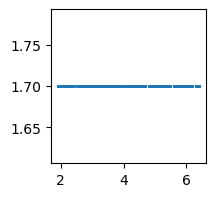

In [78]:
random_pts = np.random.choice(clusters_wall_points_arrays[12].shape[0], 2, replace=False) # 2개의 랜덤한 레이블에 속한 점 저장
selected_elements = clusters_wall_points_arrays[12][random_pts]
print("이전의 개수: ", clusters_wall_points_arrays[12].shape[0])
print("랜덤한 2개의 점: ", selected_elements)

# 평면의 방정식 -> y = selected_elements[0][1]
min = np.min(clusters_wall_points_arrays[12][:,0]) # 현재 클러스터 점들 범위
max = np.max(clusters_wall_points_arrays[12][:,0])

closest_pt, sorted_distances = find_closest_x_points(copyarr, selected_elements[0][1], min, max)

for i in range(closest_pt.shape[0]):
    if sorted_distances[i] >= 3.0: #자동차 지나가는 길 생각해서 3.0m로 잡음
        break
    elif abs(min - closest_pt[i][0]) < abs(max - closest_pt[i][0]):
        increase_pt = interpolate_points([min, selected_elements[0][1], selected_elements[0][2]], closest_pt[i])
        clusters_wall_points_arrays[12] = np.vstack((clusters_wall_points_arrays[12], increase_pt))
        min = closest_pt[i][0]
    elif abs(min - closest_pt[i][0]) > abs(max - closest_pt[i][0]):
        increase_pt = interpolate_points([max, selected_elements[0][1], selected_elements[0][2]], closest_pt[i])
        clusters_wall_points_arrays[12] = np.vstack((clusters_wall_points_arrays[12], increase_pt))
        max = closest_pt[i][0]

print("증가된 개수: ", clusters_wall_points_arrays[12].shape[0])
plt.figure(figsize=(2, 2))
plt.scatter(clusters_wall_points_arrays[12][:,0],clusters_wall_points_arrays[12][:,1], s=1)
plt.show()

##### 11 - x 축에 수직인 벽 (x=a)

이전의 개수:  1987
랜덤한 2개의 점:  [[ 6.3 19.1  1.9]
 [ 6.3 23.   1.6]]
증가된 개수:  133390


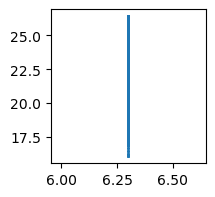

In [79]:
random_pts = np.random.choice(clusters_wall_points_arrays[11].shape[0], 2, replace=False) # 2개의 랜덤한 레이블에 속한 점 저장
selected_elements = clusters_wall_points_arrays[11][random_pts]
print("이전의 개수: ", clusters_wall_points_arrays[11].shape[0])
print("랜덤한 2개의 점: ", selected_elements)

# 평면의 방정식 -> x = selected_elements[0][0]
min = np.min(clusters_wall_points_arrays[11][:,1]) # 현재 클러스터 점들 범위
max = np.max(clusters_wall_points_arrays[11][:,1])

closest_pt, sorted_distances = find_closest_y_points(copyarr, selected_elements[0][0], min, max)

for i in range(closest_pt.shape[0]):
    if sorted_distances[i] >= 3.0: #자동차 지나가는 길 생각해서 3.0m로 잡음
        break
    elif abs(min - closest_pt[i][1]) < abs(max - closest_pt[i][1]):
        increase_pt = interpolate_points([selected_elements[0][0], min, selected_elements[0][2]], closest_pt[i])
        clusters_wall_points_arrays[11] = np.vstack((clusters_wall_points_arrays[11], increase_pt))
        min = closest_pt[i][1]
    elif abs(min - closest_pt[i][1]) > abs(max - closest_pt[i][1]):
        increase_pt = interpolate_points([selected_elements[0][0], max, selected_elements[0][2]], closest_pt[i])
        clusters_wall_points_arrays[11] = np.vstack((clusters_wall_points_arrays[11], increase_pt))
        max = closest_pt[i][1]

print("증가된 개수: ", clusters_wall_points_arrays[11].shape[0])
plt.figure(figsize=(2, 2))
plt.scatter(clusters_wall_points_arrays[11][:,0],clusters_wall_points_arrays[11][:,1], s=1)
plt.show()

#### 11에 대해 수동 조정 
##### ( 심미적인 부분을 고려하여 눈으로 확인하였을 때 스캔이 되지 않은 부분 채워줌 )

증가된 개수:  133463


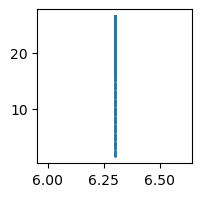

In [80]:
min = clusters_wall_points_arrays[12][0,1]
max = np.min(clusters_wall_points_arrays[11][:,1])

x_pt = clusters_wall_points_arrays[11][0,0]

lst1 = [x_pt, max, clusters_wall_points_arrays[11][0,2]]
lst2 = [x_pt, min, clusters_wall_points_arrays[11][0,2]]

increase_pt = interpolate_points(np.asarray(lst1), np.asarray(lst2))
clusters_wall_points_arrays[11] = np.vstack((clusters_wall_points_arrays[11], increase_pt))

print("증가된 개수: ", clusters_wall_points_arrays[11].shape[0])
plt.figure(figsize=(2, 2))
plt.scatter(clusters_wall_points_arrays[11][:,0],clusters_wall_points_arrays[11][:,1], s=1)
plt.show()

### 5. 평면 점 늘린 클러스터별 점들 리스트 완성

#### 점 예쁘게 & 벽 레이블별 pcd파일 저장

##### 1) 9, 11, 12 : x,y 좌표만 보고 z좌표 늘림
##### 2) 나머지: z좌표 늘리고 0 이하는 제거

In [94]:
max_z = 3

for i in range(len(wall_cluster_idx)):
    index = wall_cluster_idx[i]
    new_points = None

    if index == 9 or index == 11 or index == 12:
        unique_pts = np.unique(clusters_wall_points_arrays[index][:, :2], axis=0) # 중복 제거한 x,y 좌표로만 이루어진 점들의 집합
        for point in unique_pts:
            add_pts = interpolate_points_z(np.array([point[0], point[1], 0]), np.array([point[0], point[1], max_z]))
            if new_points is None:
                new_points = add_pts
            else:
                new_points = np.vstack((new_points, add_pts))
    else:
        filtered_points = clusters_wall_points_arrays[index][clusters_wall_points_arrays[index][:, 2] >= 0] # 0 이하 3 이상 제거
        filtered_points = clusters_wall_points_arrays[index][clusters_wall_points_arrays[index][:, 2] < 3] 
        # 원하는 값보다 z 좌표가 작은 점에 대해 z 좌표를 원하는 값까지 일정 간격으로 채우기
        for point in filtered_points:
            if point[2] < max_z:
                add_pts = interpolate_points_z(point, np.array([point[0], point[1], max_z]))
                if new_points is None:
                    new_points = add_pts
                else:
                    new_points = np.vstack((new_points, add_pts))
            else:
                if new_points is None:
                    new_points = point
                else:
                    new_points = np.vstack((new_points, point))

    unique_points = np.unique(new_points, axis=0)

    # 벽별 저장
    # 넘파이 배열을 다시 포인트 클라우드로 변환
    pcd_filtered = o3d.geometry.PointCloud()
    pcd_filtered.points = o3d.utility.Vector3dVector(unique_points)
    fname = "./object/walls/wall_" + str(i) + ".pcd"
    # 필터링된 포인트 클라우드를 PCD 파일로 저장
    o3d.io.write_point_cloud(fname, pcd_filtered)

### 6. 평면 방정식으로 기둥 완성

#### 6-1) 가로와 세로 길이 정하기
##### 중심점 구하기

In [134]:
# x좌표 기준으로 나눔 5-15, 15-25, 25-30, 30-
center_pt = []
min_width = 0
min_height = 0

max_width = 0
max_height = 0

for i in range(len(pillar_cluster_idx)):
    index = pillar_cluster_idx[i]
    # 점들 중 x,y좌표 각각의 min, max를 구하여 x_min, y_min 좌표와 x_max와 y_max의 중점을 중심점으로 함. 
    x_max = np.max(clusters_points_arrays[index][:,0])
    x_min = np.min(clusters_points_arrays[index][:,0])
    y_max = np.max(clusters_points_arrays[index][:,1])
    y_min = np.min(clusters_points_arrays[index][:,1])

    width = round(x_max - x_min, 1)
    height = round(y_max - y_min, 1)

    if i == 0:
        min_width = width
        min_height = height
    elif min_width > width:
        min_width = width
    elif max_width < width:
        max_width = width

    if min_height > height:
        min_height = height
    elif max_height < height:
        max_height = height

    center = np.array([(x_min+x_max)/2, (y_min+y_max)/2])
    center = np.round(center, 1)

    center_pt.append(center)

avg_width = round((max_width + min_width)/2, 1)
avg_height = round((max_height + min_height)/2, 1)

print(center_pt)
print(avg_width)
print(avg_height)

[array([27. , 10.6]), array([27. ,  2.2]), array([35.3, 10.6]), array([27., 19.]), array([27.2, 25.3]), array([18.4,  2.2]), array([27. , 31.4]), array([27. , 39.9]), array([18.9, 25.5]), array([27., 49.]), array([18.6, 49. ]), array([20.8,  5.6]), array([10.3, 49. ]), array([18.5, 19.7]), array([19.1, 44.6]), array([10.2, 40. ]), array([18.6, 39.8]), array([18.6, 31.5]), array([10.2, 25.3]), array([10.6, 19.4]), array([10.4, 10.7]), array([18.5, 10.6])]
1.7
1.0


#### 6-2) 비슷한 y좌표 상에 있는 중심점들끼리 모은 뒤 중심점 보정

In [141]:
pillar_class1 = []
pillar_class2 = []
pillar_class3 = []
pillar_class4 = []

for c in range(len(center_pt)):
    cmp = center_pt[c]
    cmp_x = cmp[0]

    if cmp_x >=5 and cmp_x <15:
        pillar_class1.append(cmp)
    elif cmp_x >=15 and cmp_x <25:
        pillar_class2.append(cmp)
    elif cmp_x >=25 and cmp_x <30:
        pillar_class3.append(cmp)
    elif cmp_x >=30:
        pillar_class4.append(cmp)
# ###
pillar_class1.append(np.array([10.3, 2.2]))
pillar_class1.append(np.array([10.3, 31.5]))

pillar_class2 = [arr for arr in pillar_class2 if not np.array_equal(arr, np.array([18.9, 5.6]))]
pillar_class2 = [arr for arr in pillar_class2 if not np.array_equal(arr, np.array([18.9, 44.6]))]
# ###
print(pillar_class1)
print(pillar_class2)
print(pillar_class3)
print(pillar_class4)

[array([10.3, 49. ]), array([10.3, 40. ]), array([10.3, 25.3]), array([10.3, 19.4]), array([10.3, 10.7]), array([10.3,  2.2]), array([10.3, 31.5])]
[array([18.4,  2.2]), array([18.9, 25.5]), array([18.9, 49. ]), array([18.9, 19.7]), array([18.9, 39.8]), array([18.9, 31.5]), array([18.9, 10.6])]
[array([27. , 10.6]), array([27. ,  2.2]), array([27., 19.]), array([27. , 25.3]), array([27. , 31.4]), array([27. , 39.9]), array([27., 49.])]
[array([35.3, 10.6])]


In [142]:
# 각 클래스별로 가장 첫번째에 있는 원소의 x축에 수직인 평면에 다른 원소들이 정사형(중심점 보정)
# x축에 수직인 평면은 x=a이므로 x값만 각각 바꿔주면 됨
pillar_class_all = []
pillar_class_all.append(pillar_class1)
pillar_class_all.append(pillar_class2)
pillar_class_all.append(pillar_class3)
pillar_class_all.append(pillar_class4)

for i in range(len(pillar_class_all)):
    center_base = pillar_class_all[i][0][0]
    for j in range(len(pillar_class_all[i])):
        pillar_class_all[i][j][0] = center_base # 모든 원소의 x좌표 수정

print(pillar_class_all)

[[array([10.3, 49. ]), array([10.3, 40. ]), array([10.3, 25.3]), array([10.3, 19.4]), array([10.3, 10.7]), array([10.3,  2.2]), array([10.3, 31.5])], [array([18.4,  2.2]), array([18.4, 25.5]), array([18.4, 49. ]), array([18.4, 19.7]), array([18.4, 39.8]), array([18.4, 31.5]), array([18.4, 10.6])], [array([27. , 10.6]), array([27. ,  2.2]), array([27., 19.]), array([27. , 25.3]), array([27. , 31.4]), array([27. , 39.9]), array([27., 49.])], [array([35.3, 10.6])]]


#### 6-3) 각 기둥별로 4개의 꼭짓점 저장

#### 6-4) 기둥별 pcd파일 저장

In [146]:
half_width = avg_width / 2
half_height = avg_height / 2

max_z = 3

for i in range(len(pillar_class_all)):
    add_points = None
    for j in range(len(pillar_class_all[i])):
        center_x = pillar_class_all[i][j][0]
        center_y = pillar_class_all[i][j][1]

        edge1 = np.array([center_x - half_width, center_y + half_height])
        edge2 = np.array([center_x + half_width, center_y + half_height])
        edge3 = np.array([center_x + half_width, center_y - half_height])
        edge4 = np.array([center_x - half_width, center_y - half_height])

        add_pts = interpolate_points_z_up(edge1, edge2, 0.2, max_z) # 모서리 1
        add_points = add_pts
        add_pts = interpolate_points_z_up(edge3, edge2, 0.2, max_z) # 모서리 2
        add_points = np.vstack((add_points, add_pts))
        add_pts = interpolate_points_z_up(edge4, edge3, 0.2, max_z) # 모서리 3
        add_points = np.vstack((add_points, add_pts))
        add_pts = interpolate_points_z_up(edge4, edge1, 0.2, max_z) # 모서리 4
        add_points = np.vstack((add_points, add_pts))

        # 기둥별 저장
        # 넘파이 배열을 다시 포인트 클라우드로 변환
        pcd_filtered = o3d.geometry.PointCloud()
        pcd_filtered.points = o3d.utility.Vector3dVector(add_points)
        fname = "./object/pillars/pillar" + str(i) + "_" + str(j) + ".pcd"
        # 필터링된 포인트 클라우드를 PCD 파일로 저장
        o3d.io.write_point_cloud(fname, pcd_filtered)

### 7. 전체 pcd 파일 저장 후 확인

In [147]:
import os

def merge_pcd_files(pcd_files):
    merged_pcd = o3d.geometry.PointCloud()

    for file in pcd_files:
        pcd = o3d.io.read_point_cloud(file)
        merged_pcd += pcd

    return merged_pcd

def get_all_files_in_directory(directory):
    file_list = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            file_list.append(file_path)
    return file_list

In [148]:
dir_path_wall = "./object/walls"
wall_files = get_all_files_in_directory(dir_path_wall)
dir_path_pillar = "./object/pillars"
pillar_files = get_all_files_in_directory(dir_path_pillar)

pcd_files = wall_files + pillar_files
merged_pcd = merge_pcd_files(pcd_files) # 모든 pcd 파일 합침

# 저장
o3d.io.write_point_cloud("final_map.pcd", merged_pcd)
# 시각화
o3d.visualization.draw_geometries([merged_pcd])

[Open3D WARNING] Read geometry::PointCloud failed: unknown file extension for ./object/walls/.DS_Store (format: auto).
[Open3D WARNING] Read geometry::PointCloud failed: unknown file extension for ./object/pillars/.DS_Store (format: auto).
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


: 